<center> <h1> Diagnose Latent Cytomegalovirus Using CyTOF Data and Deep Learning <h1> </center>

<center>Zicheng Hu, Ph.D.</center>
<center>Research Scientist</center>
<center>ImmPort Team</center>
<center>The Unversity of California, San Francisco</center>

![alt text](Data/header.png)

In [1]:
%matplotlib inline

In [2]:
##### Step 1: import functions #####
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Conv2D, AveragePooling2D, Input, Softmax
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
import numpy as np
from numpy.random import seed; seed(111)
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.random import set_seed; set_seed(111)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import normalize
from six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from IPython.display import Image  
import pydotplus
import time

In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
phenotype = 'Subject Age'

In [5]:
##### Step 2: load data #####

tutorial_files = ! ls Data
if "allData.obj" not in tutorial_files:
    print("Downloading Data:")
    ! wget https://ucsf.box.com/shared/static/tn8m9hco3f3gugn7z394yzimvtfdg129.obj -O ./Data/allData.obj
        
#load data
with open("FCS_to_Array/agingData.obj", "rb") as f:
    allData = pickle.load(f)
metaData = allData["samples"].reset_index().drop(columns='Unnamed: 0')
cytoData = allData['expr_list']
markerNames = allData["marker_names"]

print("Dimensions of cytoData: ",cytoData.shape,"\n")
print("Names of the makers: \n",markerNames.values)

Dimensions of cytoData:  (753, 20000, 13, 1) 

Names of the makers: 
 ['FSC-A' 'FSC-H' 'FSC-W' 'SSC-A' 'SSC-H' 'SSC-W' 'PSTAT1' 'PSTAT5' 'CD66B'
 'CD33' 'CD3/CD14' 'PSTAT3' 'CD4/CD19']


In [6]:
metaData['Expsample Treatement'].value_counts()

IL-10               154
IL-6                151
interferon alpha    150
IL-21               149
Unstim              149
Name: Expsample Treatement, dtype: int64

In [7]:
##### Step 3: split train, validation and test######
phenotype = 'Subject Age'
stimulation = 'interferon alpha'
x = []
y = []
for i, row in metaData[(metaData['Expsample Treatement']==stimulation) & (metaData['Age Unit']=='Years')].iterrows():
    x.append(cytoData[i])
    y.append(row[phenotype])
age_range = max(y) - min(y)
x = np.asarray(x)
y_raw = np.asarray(y)
age_min = min(y_raw)
age_max = max(y_raw)
age_range = age_max - age_min
y = (y_raw - age_min) / age_range

x_train, x_valid, y_train, y_valid = train_test_split(x, y)

<AxesSubplot:ylabel='Frequency'>

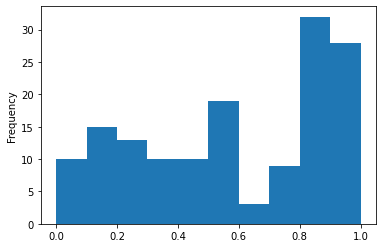

In [8]:
pd.Series(y).plot.hist()

In [9]:
y.shape

(149,)

In [11]:
aging_model = Sequential([
    Input(shape=x[0].shape),
    Conv2D(3, kernel_size = (1, x.shape[2]), activation=None),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(3, kernel_size = (1,1), activation=None),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size = (x.shape[1], 1)),
    Flatten(),
    Dense(3, activation=None),
    BatchNormalization(),
    Activation('relu'),
    Dense(1, activation=None),
#     BatchNormalization(),
#     Activation('sigmoid'),
])
aging_model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics=['mean_absolute_error'])
aging_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20000, 1, 3)       42        
_________________________________________________________________
batch_normalization (BatchNo (None, 20000, 1, 3)       12        
_________________________________________________________________
activation (Activation)      (None, 20000, 1, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20000, 1, 3)       12        
_________________________________________________________________
batch_normalization_1 (Batch (None, 20000, 1, 3)       12        
_________________________________________________________________
activation_1 (Activation)    (None, 20000, 1, 3)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 3)           0

In [12]:
model = aging_model

# save the best performing model
checkpointer = ModelCheckpoint(filepath='Result/saved_weights.hdf5', 
                               monitor='val_loss', verbose=0, 
                               save_best_only=True)

st = time.time()
# model training
model.fit([x_train], y_train,
          batch_size=60,
          epochs=150, 
          verbose=1,
          callbacks=[checkpointer],
          validation_data=([x_valid], y_valid))
rt = time.time()-st

Epoch 1/150
2/2 [==============================] - 4s 1s/step - loss: 0.4946 - mean_absolute_error: 0.4946 - val_loss: 0.5654 - val_mean_absolute_error: 0.5654
Epoch 2/150
2/2 [==============================] - 0s 78ms/step - loss: 0.4880 - mean_absolute_error: 0.4880 - val_loss: 0.5634 - val_mean_absolute_error: 0.5634
Epoch 3/150
2/2 [==============================] - 0s 75ms/step - loss: 0.4733 - mean_absolute_error: 0.4733 - val_loss: 0.5614 - val_mean_absolute_error: 0.5614
Epoch 4/150
2/2 [==============================] - 0s 77ms/step - loss: 0.4790 - mean_absolute_error: 0.4790 - val_loss: 0.5594 - val_mean_absolute_error: 0.5594
Epoch 5/150
2/2 [==============================] - 0s 76ms/step - loss: 0.4719 - mean_absolute_error: 0.4719 - val_loss: 0.5574 - val_mean_absolute_error: 0.5574
Epoch 6/150
2/2 [==============================] - 0s 76ms/step - loss: 0.4561 - mean_absolute_error: 0.4561 - val_loss: 0.5554 - val_mean_absolute_error: 0.5554
Epoch 7/150
2/2 [=============

In [13]:
rt

25.359264373779297

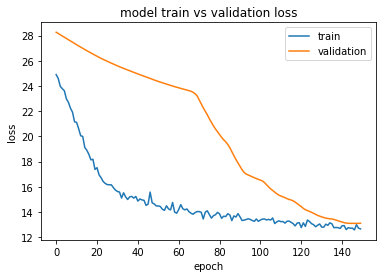

In [14]:
##### Step 6: plot train and validation loss #####
history = model.history
plt.plot(age_range*pd.Series(history.history['mean_absolute_error']))
plt.plot(age_range*pd.Series(history.history['val_mean_absolute_error']))
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

count    38.000000
mean     39.329406
std      15.442524
min      14.935036
25%      26.694522
50%      39.505935
75%      52.529742
max      63.372478
dtype: float64


<AxesSubplot:ylabel='Frequency'>

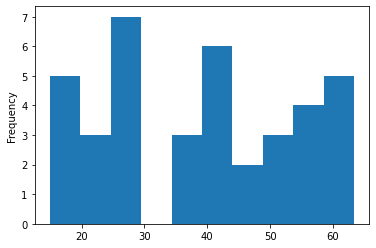

In [15]:
#### Step 7: test the final model #####
final_model = model
# load final model
# final_model = load_model('Data/Final_weights.hdf5')
x_test = x_valid
y_test = y_valid

# generate ROC and AUC
y_scores = final_model.predict([x_test])
y_scores = y_scores.reshape(y_scores.shape[0])
errors = age_range * (pd.Series(y_scores)-pd.Series(y_valid)) + age_min
print(errors.describe())
errors.plot.hist()